# Load libraries and files

In [1]:
# Import Libraries
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import norm, skew
from scipy.stats.stats import pearsonr

from sklearn import ensemble, tree, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.3f' %x)
import warnings
warnings.filterwarnings('ignore')

# Look for Files
import os
print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
# Make dataframe for train and test sets
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
print('Train dataframe size: ', df_train.shape)
print('Test dataframe size: ', df_test.shape)

Train dataframe size:  (1460, 81)
Test dataframe size:  (1459, 80)


In [3]:
# View sample of data
df_train.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1191,1192,160,FV,24.000,2645,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,8,5,1999,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,456.000,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,776,776,GasA,...,Y,SBrkr,764,677,0,1441,0,0,2,1,2,1,Gd,5,Typ,0,NaN,Detchd,1999.000,Unf,2,492,TA,TA,Y,206,0,0,0,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal,174000
219,220,120,RL,43.000,3010,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,16.000,Gd,TA,PConc,Gd,TA,Av,GLQ,16,Unf,0,1232,1248,GasA,...,Y,SBrkr,1248,0,0,1248,0,0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,2005.000,Fin,2,438,TA,TA,Y,108,0,0,0,0,0,NaN,NaN,NaN,0,3,2006,New,Partial,167240
131,132,60,RL,nan,12224,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,40.000,Gd,TA,PConc,Gd,TA,No,GLQ,695,Unf,0,297,992,GasA,...,Y,SBrkr,1022,1032,0,2054,1,0,2,1,3,1,Gd,7,Typ,1,TA,BuiltIn,2000.000,RFn,2,390,TA,TA,Y,24,48,0,0,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal,244000
516,517,80,RL,nan,10448,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,Norm,Norm,1Fam,SLvl,6,6,1972,1972,Gable,CompShg,HdBoard,HdBoard,BrkFace,333.000,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,689,689,GasA,...,Y,SBrkr,1378,741,0,2119,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1972.000,RFn,2,583,TA,TA,Y,0,104,0,0,0,0,NaN,GdPrv,NaN,0,8,2009,COD,Abnorml,158000
1320,1321,20,RL,70.000,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,3,1957,1957,Hip,CompShg,BrkFace,BrkFace,None,0.000,TA,TA,CBlock,TA,TA,No,ALQ,189,Rec,661,628,1478,GasA,...,Y,SBrkr,1478,0,0,1478,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1957.000,RFn,2,442,TA,TA,Y,114,0,0,0,216,0,NaN,NaN,NaN,0,6,2009,WD,Normal,156500
446,447,20,RL,137.000,16492,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,PosA,Norm,1Fam,1Story,6,6,1966,2002,Gable,CompShg,BrkFace,Plywood,None,0.000,Gd,TA,CBlock,TA,TA,No,ALQ,247,Rec,713,557,1517,GasA,...,Y,SBrkr,1888,0,0,1888,0,0,2,1,2,1,Gd,6,Mod,1,Gd,Attchd,1966.000,Fin,2,578,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,190000
559,560,120,RL,nan,3196,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,18.000,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,1374,1374,GasA,...,Y,SBrkr,1557,0,0,1557,0,0,2,0,2,1,Gd,7,Typ,1,TA,Attchd,2003.000,Fin,2,420,TA,TA,Y,143,20,0,0,0,0,NaN,NaN,NaN,0,10,2006,WD,Normal,234000
695,696,20,RL,54.000,13811,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,6,6,1987,1987,Gable,CompShg,HdBoard,HdBoard,BrkFace,72.000,TA,TA,CBlock,Gd,Gd,No,GLQ,980,LwQ,40,92,1112,GasA,...,Y,SBrkr,1137,0,0,1137,1,0,2,0,2,1,Gd,5,Typ,1,TA,Attchd,1987.000,Unf,2,551,TA,TA,Y,125,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
1285,1286,50,RM,50.000,6000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Fin,6,6,1939,1950,Gabl

In [4]:
# Get list of all features
features = df_train.columns.tolist()
print('Features:')
features

Features:


['Id',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF'

In [5]:
# Describe features
df_train.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000,1460.000,1460,1201.000,1460.000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000,1460.000,1460.000,1460.000,1460,1460,1460,1460,1452,1452.000,1460,1460,1460,1423,1423,1422,1423,1460.000,1422,1460.000,1460.000,1460.000,1460,...,1460,1459,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460,1460.000,1460,1460.000,770,1379,1379.000,1379,1460.000,1460.000,1379,1379,1460,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,7,281,54,1460.000,1460.000,1460.000,1460,1460,1460.000
unique,nan,nan,5,nan,nan,2,2,4,4,2,5,3,25,9,8,5,8,nan,nan,nan,nan,6,8,15,16,4,nan,4,5,6,4,4,4,6,nan,6,nan,nan,nan,6,...,2,5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4,nan,7,nan,5,6,nan,3,nan,nan,5,5,3,nan,nan,nan,nan,nan,nan,3,4,4,nan,nan,nan,9,6,nan
top,nan,nan,RL,nan,nan,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,nan,nan,nan,nan,Gable,CompShg,VinylSd,VinylSd,None,nan,TA,TA,PConc,TA,TA,No,Unf,nan,Unf,nan,nan,nan,GasA,...,Y,SBrkr,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,TA,nan,Typ,nan,Gd,Attchd,nan,Unf,nan,nan,TA,TA,Y,nan,nan,nan,nan,nan,nan,Gd,MnPrv,Shed,nan,nan,nan,WD,Normal,nan
freq,nan,nan,1151,nan,nan,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,nan,nan,nan,nan,1141,1434,515,504,864,nan,906,1282,647,649,1311,953,430,nan,1256,nan,nan,nan,1428,...,1365,1334,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,735,nan,1360,nan,380,870,nan,605,nan,nan,1311,1326,1340,nan,nan,nan,nan,nan,nan,3,157,49,nan,nan,nan,1267,1198,nan
mean,730.500,56.897,NaN,70.050,10516.828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099,5.575,1971.268,1984.866,NaN,NaN,NaN,NaN,NaN,103.685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.640,NaN,46.549,567.240,1057.429,NaN,...,NaN,NaN,1162.627,346.992,5.845,1515.464,0.425,0.058,1.565,0.383,2.866,1.047,NaN,6.518,NaN,0.613,NaN,NaN,1978.506,NaN,1.767,472.980,NaN,NaN,NaN,94.245,46.660,21.954,3.410,15.061,2.759,NaN,NaN,NaN,43.489,6.322,2007.816,NaN,NaN,180921.196
std,421.610,42.301,NaN,24.285,9981.265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.383,1.113,30.203,20.645,NaN,NaN,NaN,NaN,NaN,181.066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098,NaN,161.319,441.867,438.705,NaN,...,NaN,NaN,386.588,436.528,48.623,525.480,0.519,0.239,0.551,0.503,0.816,0.220,NaN,1.625,NaN,0.645,NaN,NaN,24.690,NaN,0.747,213.805,NaN,NaN,NaN,125.339,66.256,61.119,29.317,55.757,40.177,NaN,NaN,NaN,496.123,2.704,1.328,NaN,NaN,79442.503
min,1.000,20.000,NaN,21.000,1300.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1.000,1872.000,1950.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,0.000,0.000,NaN,...,NaN,NaN,334.000,0.000,0.000,334.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,2.000,NaN,0.000,NaN,NaN,1900.000,NaN,0.000,0.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.000,1.000,2006.000,NaN,NaN,34900.000
25%,365.750,20.000,NaN,59.000,7553.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000,5.000,1954.000,1967.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,223.000,795.750,NaN,...,NaN,NaN,882.000,0.000,0.000,1129.500,0.000,0.000,1.000,0.000,2.000,1.000,NaN,5.000,NaN,0.000,NaN,NaN,

In [6]:
# Make sure there are no duplicate ids
idsUnique = len(set(df_train.Id))
idsTotal = df_train.shape[0]
idsDup = idsTotal - idsUnique
if idsDup>0: print('DUPLICATE IDS FOUND')
    
# Remove ID column from dataframe
train_IDs = df_train.Id
df_train.drop('Id', axis=1, inplace=True)
test_IDs = df_test.Id
df_test.drop('Id', axis=1, inplace=True)
features.remove('Id')

print('ID column dropped')
print('Train dataframe size: ', df_train.shape)
print('Test dataframe size: ', df_test.shape)

ID column dropped
Train dataframe size:  (1460, 80)
Test dataframe size:  (1459, 79)


# Coorelate features to eachother and to sales price

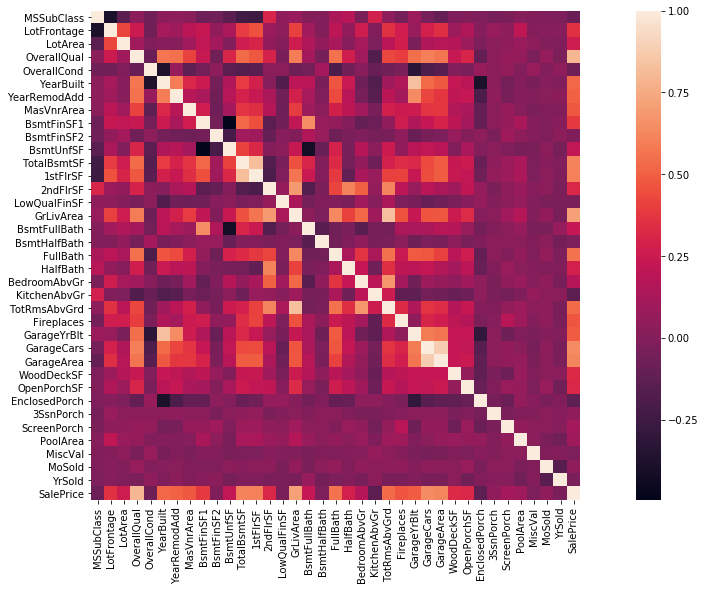

In [7]:
# Coorelation plot
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(20,9))
sns.heatmap(corrmat, square=True)

In [8]:
# Identify which features are most coorelated to eachother (redundant features)
corr_cutoff = 0.7
top_corrmat = pd.DataFrame(columns=['Feature_Correlation','Feature_1', 'Price_Correlation_1','Feature_2', 'Price_Correlation_2'])
for feature in corrmat.columns.tolist():
    temp_list = corrmat.index[abs(corrmat[feature])>corr_cutoff].tolist()
    temp_list.remove(feature) #remove diagnol elements
    if 'SalePrice' in temp_list: temp_list.remove('SalePrice') #ignore sale price for now
    if (len(temp_list)>0) & (feature != 'SalePrice'):
        for each in temp_list:
            if each not in top_corrmat['Feature_1'].values.tolist():
                feature_corr = corrmat.loc[feature, each]
                f1_sale = corrmat.loc[feature, 'SalePrice']
                f2_sale = corrmat.loc[each, 'SalePrice']
                top_corrmat = top_corrmat.append({'Feature_1': feature, 'Price_Correlation_1': f1_sale,'Feature_2': each, 'Feature_Correlation': feature_corr, 'Price_Correlation_2':f2_sale}, ignore_index=True)

print('Top Coorelated Features (cutoff = 0.7):')
top_corrmat

Top Coorelated Features (cutoff = 0.7):


,Feature_Correlation,Feature_1,Price_Correlation_1,Feature_2,Price_Correlation_2
0,0.826,YearBuilt,0.523,GarageYrBlt,0.486
1,0.820,TotalBsmtSF,0.614,1stFlrSF,0.606
2,0.825,GrLivArea,0.709,TotRmsAbvGrd,0.534
3,0.882,GarageCars,0.640,GarageArea,0.623


In [9]:
# For each pair remove feature less coorelated with price
features.remove('GarageYrBlt')
features.remove('1stFlrSF')
features.remove('TotRmsAbvGrd')
features.remove('GarageArea')
print('Updated Features List:')
features

Updated Features List:


['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'Poo

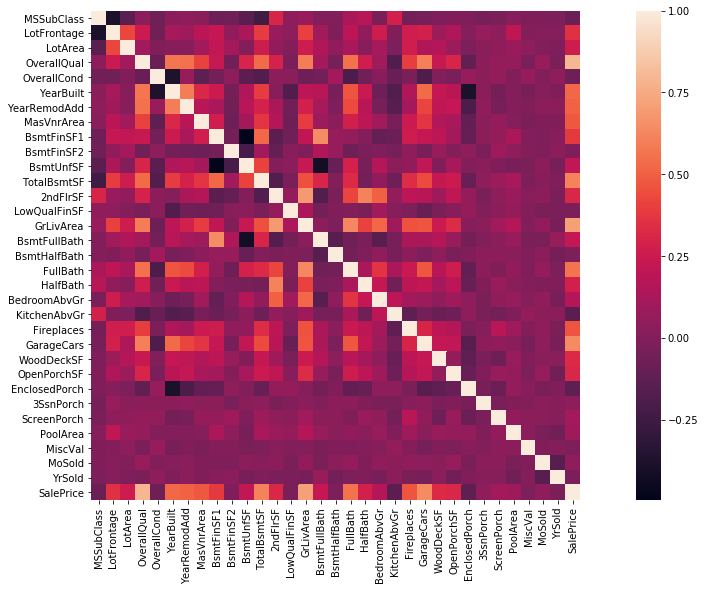

In [10]:
# Update datagframes with new feature list
df_train = df_train[features]
temp_features = [i for i in features if i != 'SalePrice']
df_test = df_test[temp_features]

# Correlation plot
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(20,9))
sns.heatmap(corrmat, square=True)

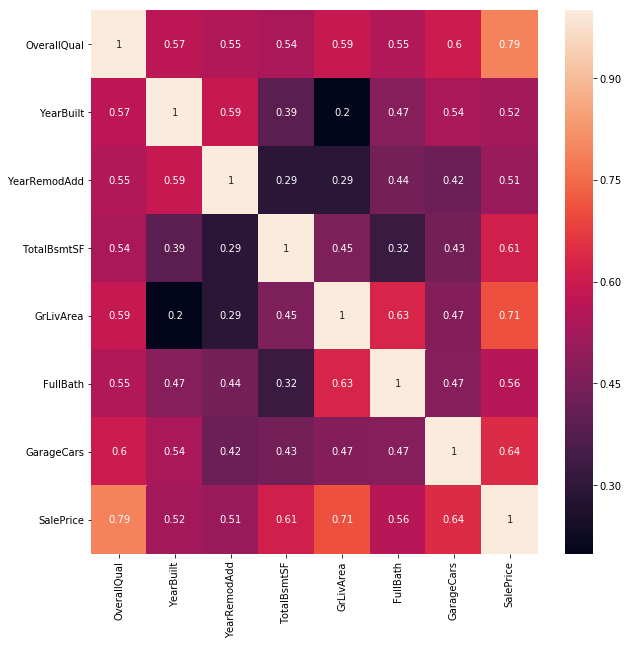

In [11]:
# Find features most coorelated with sale price
corr_cutoff = 0.5
top_corr_features = corrmat.index[abs(corrmat['SalePrice'])>corr_cutoff]
plt.figure(figsize=(10,10))
g=sns.heatmap(df_train[top_corr_features].corr(), annot=True)

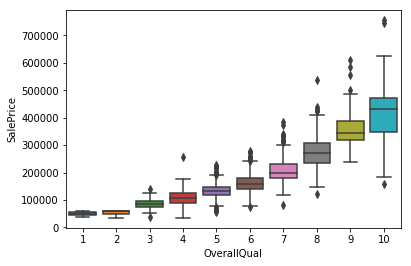

In [12]:
# Plot for most coorelated feature
sns.boxplot(x='OverallQual', y='SalePrice', data=df_train)

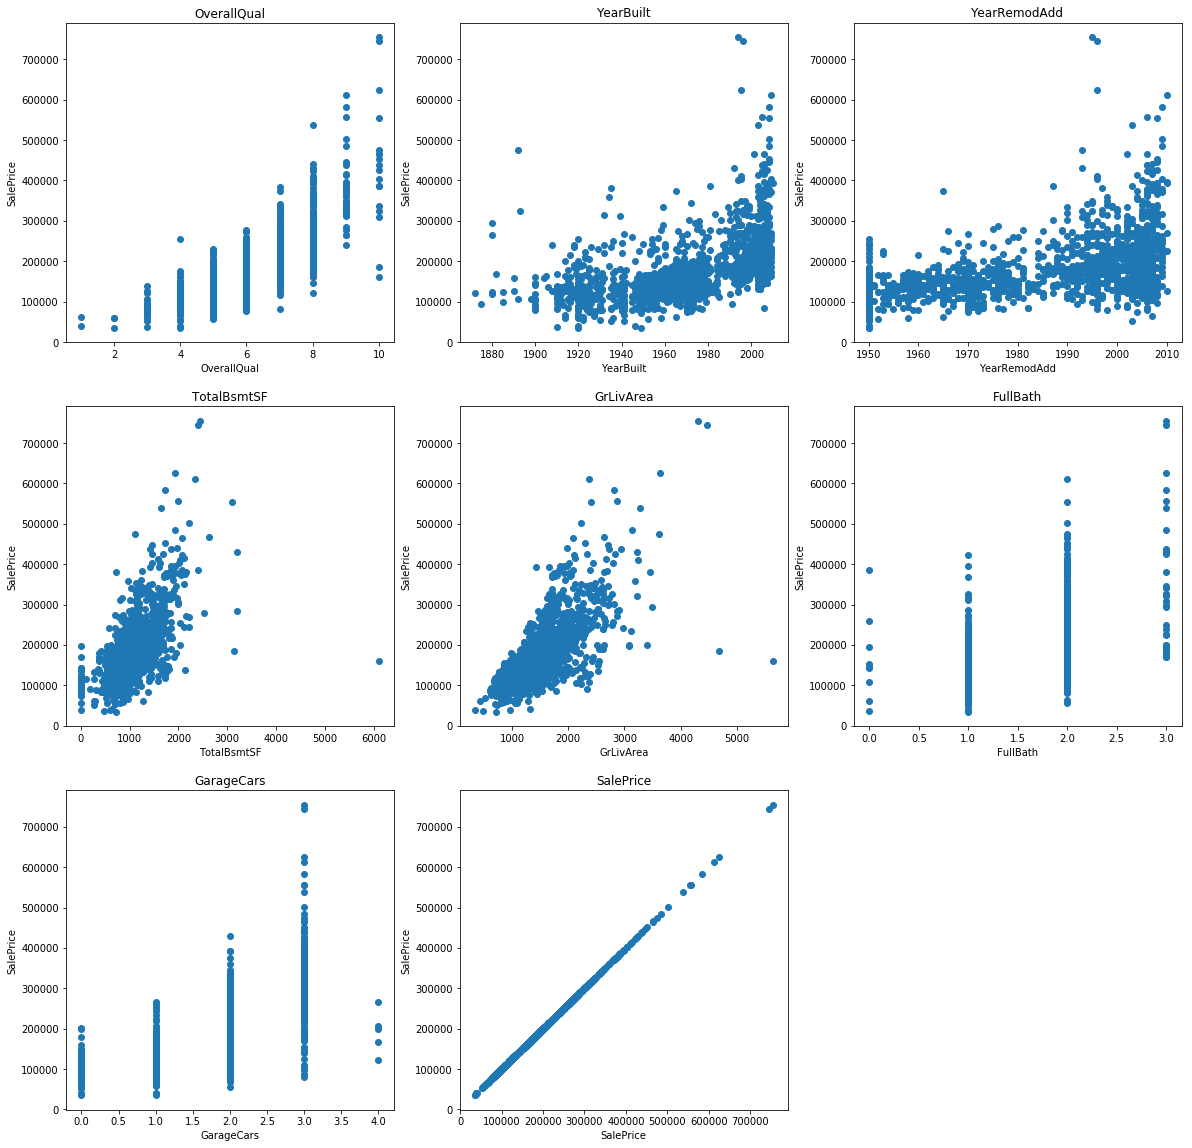

In [13]:
# Scatterplots for top features
top_corr_features.drop('SalePrice')
plt.figure(figsize=(20,20))
nrows = str(int(np.ceil(len(top_corr_features)/3)))
ncols = str(3)
i=1
for feature in top_corr_features:
    plt.subplot(nrows, ncols, i)
    plt.scatter(df_train[feature], df_train.SalePrice)
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(feature)
    i += 1

In [14]:
# Remove outliers
df_train = df_train[df_train.TotalBsmtSF < 5000]
df_train = df_train[(df_train.GrLivArea < 4000) | (df_train.SalePrice > 600000)]

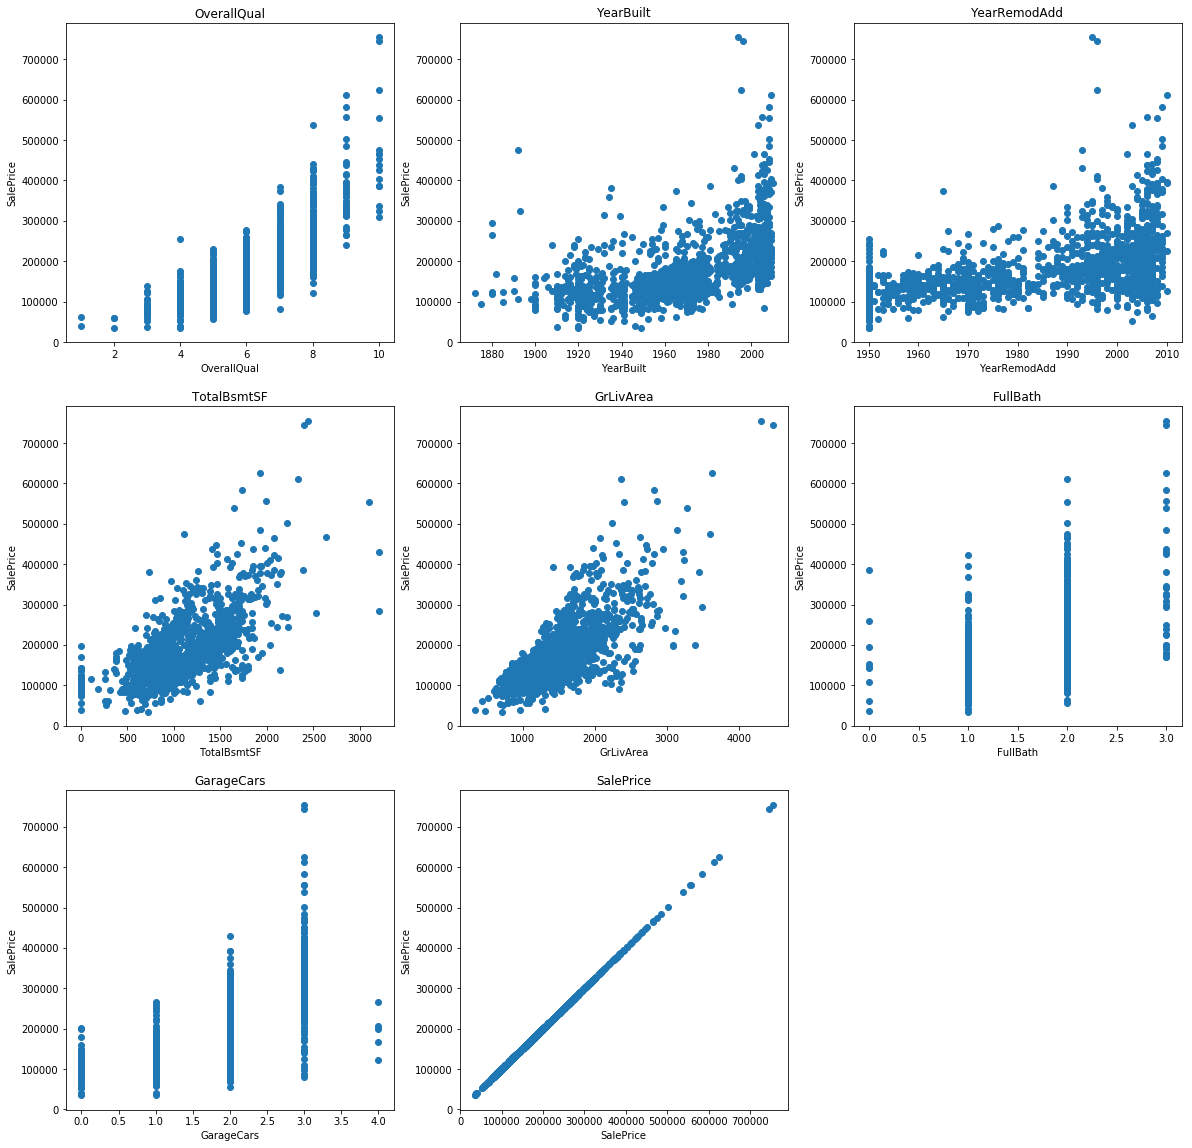

In [15]:
# Replot distributions
plt.figure(figsize=(20,20))
nrows = str(int(np.ceil(len(top_corr_features)/3)))
ncols = str(3)
i=1
for feature in top_corr_features:
    plt.subplot(nrows, ncols, i)
    plt.scatter(df_train[feature], df_train.SalePrice)
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(feature)
    i += 1

# Create combined feature dataframe for data cleaning
# Divide up numerical and categorical features

In [16]:
# Save number of entries for each dataframe
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

# combine train and test data with train on top
all_data = pd.concat((df_train, df_test))

# drop SalePrice from features
all_data.drop('SalePrice', axis=1, inplace=True)

print ('Dataframe sizes:')
print('Train: ', df_train.shape)
print('Test: ', df_test.shape)
print('All Data', all_data.shape)

Dataframe sizes:
Train:  (1458, 76)
Test:  (1459, 75)
All Data (2917, 75)


In [17]:
# Separate feeatures into numerical and calegorical
cat_features = all_data.select_dtypes(include=['object']).columns.values.tolist()
num_features = all_data.select_dtypes(exclude=['object']).columns.values.tolist()
print(len(cat_features), ' Cat Features')
print(cat_features)
print(len(num_features), ' Num Features')
print(num_features)

43  Cat Features
['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']
32  Num Features
['2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageCars', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch', 'TotalBsmt

In [18]:
# recategorize cat features that look like num features
new_cat = ['MSSubClass', 'MoSold', 'OverallCond', 'OverallQual']
for each in new_cat:
    cat_features.append(each)
    num_features.remove(each)
print(len(cat_features), ' Cat Features')
print(cat_features)
print(len(num_features), ' Num Features')
print(num_features)

47  Cat Features
['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities', 'MSSubClass', 'MoSold', 'OverallCond', 'OverallQual']
28  Num Features
['2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageCars', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmt

In [19]:
# Save dataframes for each feature type
num_data = all_data[num_features]
cat_data = all_data[cat_features]

# Find Missing Values

## Fill with specific value
### NA
Alley            object

Fence            object 

FireplaceQu      object

MiscFeature      object 

PoolQC           object 


### Typ
Functional       object

### TA
KitchenQual      object

### Median of Neighborhood
LotFrontage     float64

### Mode of Neighborhood
MSZoning         object 

SaleType         object 

Utilities        object 

Electrical       object 

Exterior1st      object 

Exterior2nd      object 


### 0
MasVnrArea      float64 

### None
MasVnrType       object 

## Determine if area exists
look for cat feature other than NA or sum of num features  >0
if exists, fill with mode/median of neighborhood
else fill with None/0

### Basement
BsmtCond         object 

BsmtExposure     object 

BsmtFinType1     object

BsmtFinType2     object 

BsmtQual         object 


BsmtFinSF1      float64 

BsmtFinSF2      float64 

BsmtFullBath    float64 

BsmtHalfBath    float64 

BsmtUnfSF       float64 

TotalBsmtSF     float64 


### Garage
GarageCond       object 

GarageFinish     object 

GarageQual       object 

GarageType       object 


GarageArea      float64 

GarageCars      float64 

GarageYrBlt     float64 


In [20]:
# Find which features have missing data
all_data_missing = all_data.isnull().sum()
all_data_missing = all_data_missing[all_data_missing>0]
all_data_missing.sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageFinish     159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtUnfSF          1
Electrical         1
Exterior1st        1
SaleType           1
TotalBsmtSF        1
BsmtFinSF2         1
BsmtFinSF1         1
GarageCars         1
KitchenQual        1
Exterior2nd        1
dtype: int64

In [21]:
all_data[all_data_missing.index].dtypes

Alley            object
BsmtCond         object
BsmtExposure     object
BsmtFinSF1      float64
BsmtFinSF2      float64
BsmtFinType1     object
BsmtFinType2     object
BsmtFullBath    float64
BsmtHalfBath    float64
BsmtQual         object
BsmtUnfSF       float64
Electrical       object
Exterior1st      object
Exterior2nd      object
Fence            object
FireplaceQu      object
Functional       object
GarageCars      float64
GarageCond       object
GarageFinish     object
GarageQual       object
GarageType       object
KitchenQual      object
LotFrontage     float64
MSZoning         object
MasVnrArea      float64
MasVnrType       object
MiscFeature      object
PoolQC           object
SaleType         object
TotalBsmtSF     float64
Utilities        object
dtype: object

In [22]:
# Look for coorelated features to detemine importance of each feature
corr_cutoff = 0.5
for each in all_data_missing.index:
    if all_data[each].dtype =='float64':
        top_features = corrmat.index[abs(corrmat[each])>corr_cutoff].values.tolist()
        top_features.remove(each)
        for ea in top_features:
            if ea not in all_data_missing.index:
                print(each, ': ', ea, ', ', corrmat[each][ea])

GarageCars :  OverallQual ,  0.6006707165907189
GarageCars :  YearBuilt ,  0.5378500917111045
GarageCars :  SalePrice ,  0.640409197258349
TotalBsmtSF :  OverallQual ,  0.5378084986123927
TotalBsmtSF :  SalePrice ,  0.6135805515591944


In [23]:
# Fill missing values as listed in above comment
temp_list=['Alley', 'Fence', 'FireplaceQu', 'MiscFeature', 'PoolQC']
temp_value='NA'
for each in temp_list:
    all_data.loc[:, each] = all_data.loc[:, each].fillna(temp_value)

temp_list=['Functional']
temp_value='Typ'
for each in temp_list:
    all_data.loc[:, each] = all_data.loc[:, each].fillna(temp_value)

temp_list=['KitchenQual']
temp_value='TA'
for each in temp_list:
    all_data.loc[:, each] = all_data.loc[:, each].fillna(temp_value)

temp_list=['MasVnrType']
temp_value='None'
for each in temp_list:
    all_data.loc[:, each] = all_data.loc[:, each].fillna(temp_value)
    
temp_list=['MasVnrArea']
temp_value=0
for each in temp_list:
    all_data.loc[:, each] = all_data.loc[:, each].fillna(temp_value)

temp_list=['LotFrontage']
for each in temp_list:
    all_data.loc[:, each] = all_data.groupby(by='Neighborhood')[each].transform(lambda x: x.fillna(x.median()))

temp_list=['MSZoning', 'SaleType', 'Utilities', 'Electrical', 'Exterior1st', 'Exterior2nd']
for each in temp_list:
    all_data.loc[:, each] = all_data.groupby(by='Neighborhood')[each].transform(lambda x: x.fillna(x.mode()[0]))

In [24]:
# Basement Features
cat_Bsmt = [i for i in cat_features if 'Bsmt' in i]
num_Bsmt = [i for i in num_features if 'Bsmt' in i]
all_Bsmt = cat_Bsmt + num_Bsmt
temp_array = []
for index, row in all_data[all_data[all_Bsmt].isnull().any(axis=1)].iterrows():
    include=False
    for each in num_Bsmt:
        if row[each]>0: include=True
    for each in cat_Bsmt:
        if type(row[each])==str:
            if row[each] != 'NA': include=True
    if include: 
        temp_array.append(index)
        for each in num_Bsmt:
            all_data.loc[index, each] = all_data.groupby(by='Neighborhood')[each].transform(lambda x: x.fillna(x.median())).iloc[index]
        for each in cat_Bsmt:
            all_data.loc[index, each] = all_data.groupby(by='Neighborhood')[each].transform(lambda x: x.fillna(x.mode()[0])).iloc[index]
    else:
        for each in num_Bsmt:
            all_data.loc[index, each] = 0
        for each in cat_Bsmt:
            all_data.loc[index, each] = 'NA'

print('Remaining missing data for Basement:')
all_data[all_Bsmt].isnull().sum()

Remaining missing data for Basement:


BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtFullBath    0
BsmtHalfBath    0
BsmtUnfSF       0
TotalBsmtSF     0
dtype: int64

In [25]:
# Garage Features
cat_Gar = [i for i in cat_features if 'Garage' in i]
num_Gar = [i for i in num_features if 'Garage' in i]
all_Gar = cat_Gar + num_Gar
temp_array = []
for index, row in all_data[all_data[all_Gar].isnull().any(axis=1)].iterrows():
    include=False
    for each in num_Gar:
        if row[each]>0: include=True
    for each in cat_Gar:
        if type(row[each])==str:
            if row[each] != 'NA': include=True
    if include: 
        temp_array.append(index)
        for each in num_Gar:
            all_data.loc[index, each] = all_data.groupby(by='Neighborhood')[each].transform(lambda x: x.fillna(x.median())).iloc[index]
        for each in cat_Gar:
            all_data.loc[index, each] = all_data.groupby(by='Neighborhood')[each].transform(lambda x: x.fillna(x.mode()[0])).iloc[index]
    else:
        for each in num_Gar:
            all_data.loc[index, each] = 0
        for each in cat_Gar:
            all_data.loc[index, each] = 'NA'

print('Remaining missing data for Garage:')
all_data[all_Gar].isnull().sum()

Remaining missing data for Garage:


GarageCond      0
GarageFinish    0
GarageQual      0
GarageType      0
GarageCars      0
dtype: int64

In [26]:
num_data = all_data[num_features]
cat_data = all_data[cat_features]
print('Number of Missing Values')
np.max(all_data.isnull().sum())

Number of Missing Values


0

# Look at Sales Price (Target Value)
Plot histogram of sales prices and compare to normal distribution
Since there is a poor fit, take the log and try again

mu = 180932.919067 and sigma = 79467.788930


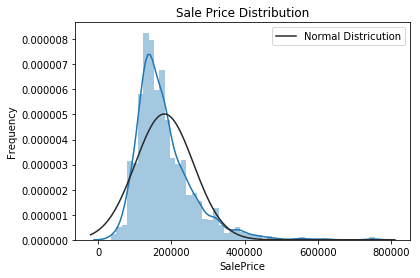

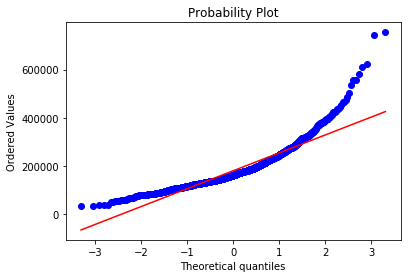

In [27]:
# Plot sale prices against Normal Distribution
df_target = df_train.SalePrice
sns.distplot(df_target, fit=norm)
(mu, sigma) = norm.fit(df_target)
print('mu = {:2f} and sigma = {:2f}'.format(mu,sigma))
plt.legend(['Normal Districution'], loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price Distribution')
fig = plt.figure()
res = stats.probplot(df_target, plot=plt)
plt.show()

mu = 12.024015 and sigma = 0.399576


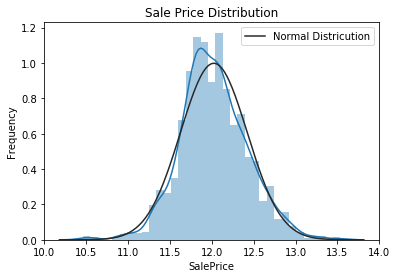

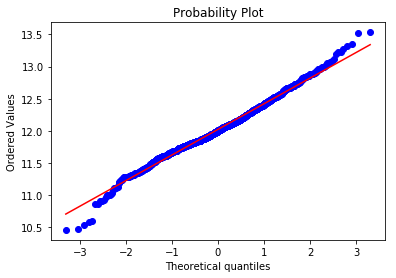

In [28]:
# Log transform target
df_target = np.log1p(df_target) #log of price + 1
sns.distplot(df_target, fit=norm)
(mu, sigma) = norm.fit(df_target)
print('mu = {:2f} and sigma = {:2f}'.format(mu,sigma))
plt.legend(['Normal Districution'], loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price Distribution')
fig = plt.figure()
res = stats.probplot(df_target, plot=plt)
plt.show()

# Numerical Features
Check for skew
Take log

In [29]:
# Check for skew and transforms those with high skew
skew_cutoff = 0.5
skew_values = num_data.apply(lambda x: skew(x))
skew_values = skew_values[abs(skew_values)>skew_cutoff]
print(skew_values.sort_values(ascending=False))
skew_features = skew_values.index
num_data[skew_features] = np.log1p(num_data[skew_features])

MiscVal         21.940
PoolArea        17.689
LotArea         13.109
LowQualFinSF    12.085
3SsnPorch       11.372
KitchenAbvGr     4.301
BsmtFinSF2       4.216
EnclosedPorch    4.002
BsmtHalfBath     3.989
ScreenPorch      3.945
MasVnrArea       2.622
OpenPorchSF      2.529
WoodDeckSF       1.845
LotFrontage      1.103
GrLivArea        1.069
BsmtFinSF1       1.003
BsmtUnfSF        0.937
2ndFlrSF         0.862
Fireplaces       0.725
HalfBath         0.697
BsmtFullBath     0.648
YearBuilt       -0.599
dtype: float64


In [30]:
# Normalize values
stdSc = StandardScaler()
num_data.loc[:,num_features] = stdSc.fit_transform(num_data.loc[:,num_features])

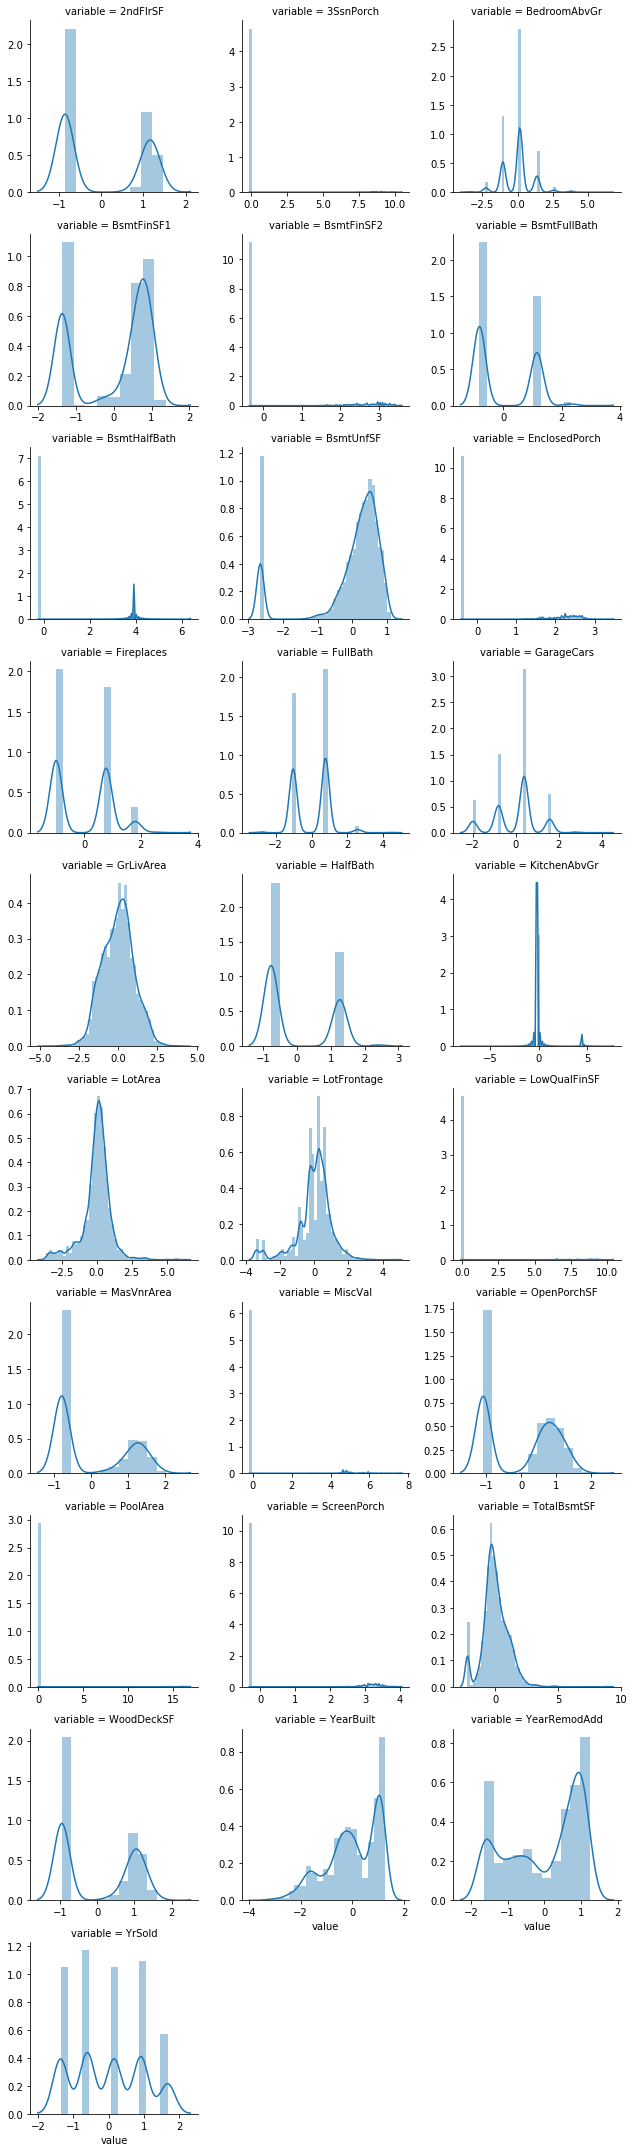

In [31]:
# Plot distribution of transformed and normalized numerical features
f=pd.melt(num_data, value_vars = num_features)
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False)
g=g.map(sns.distplot, "value")

# Categorical Features

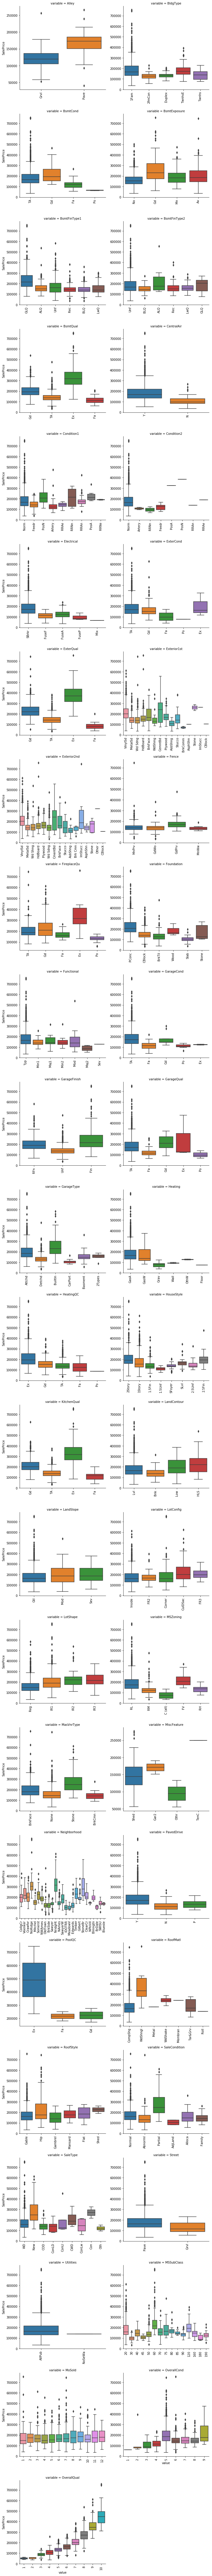

In [32]:
# Plot Cateogrical Features
for each in cat_features:
    cat_data[each] = cat_data[each].astype('category')
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x,y=y)
    x=plt.xticks(rotation=90)
f=pd.melt(df_train, id_vars=['SalePrice'], value_vars = cat_features)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g=g.map(boxplot, "value", "SalePrice")


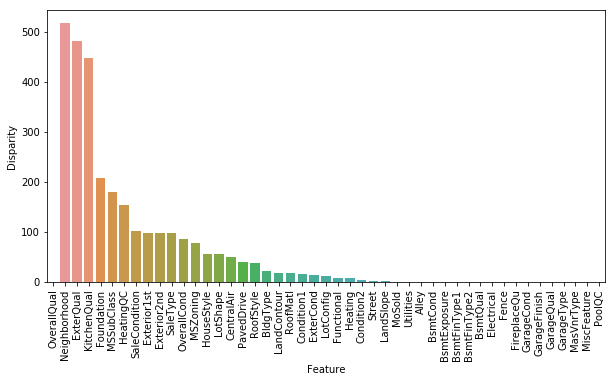

In [33]:
# Test for differences between feature categories (ANOVA)
anova = pd.DataFrame()
anova['Feature'] = cat_features
values = []
for feature in cat_features:
    prices = []
    for cat in df_train[feature].unique():
        s = df_train[df_train[feature]==cat]['SalePrice'].values
        prices.append(s)
    pval = stats.f_oneway(*prices)[1]
    values.append(pval)
anova['Values'] = values
anova.sort_values('Values', inplace=True)
anova['Disparity'] = np.log(1./anova['Values'].values)

# Plot disparity by category
plt.figure(figsize=(10,5))
sns.barplot(data=anova, x='Feature', y='Disparity')
x=plt.xticks(rotation=90)

In [34]:
# Create Dummy Variables for cateories
cat_data = pd.get_dummies(cat_data)

In [35]:
# Data Frame Sizes
print('Data Frame Sizes after expanding categorical features:')
print('Num Data: ', num_data.shape)
print('Cat Data: ', cat_data.shape)
all_data = pd.concat([num_data, cat_data], axis=1, ignore_index=False)
print('All Data: ', all_data.shape)

Data Frame Sizes after expanding categorical features:
Num Data:  (2917, 28)
Cat Data:  (2917, 312)
All Data:  (2917, 340)


# Identify uncoorelated Features to remove
Reduce number of features to avoid overfitting

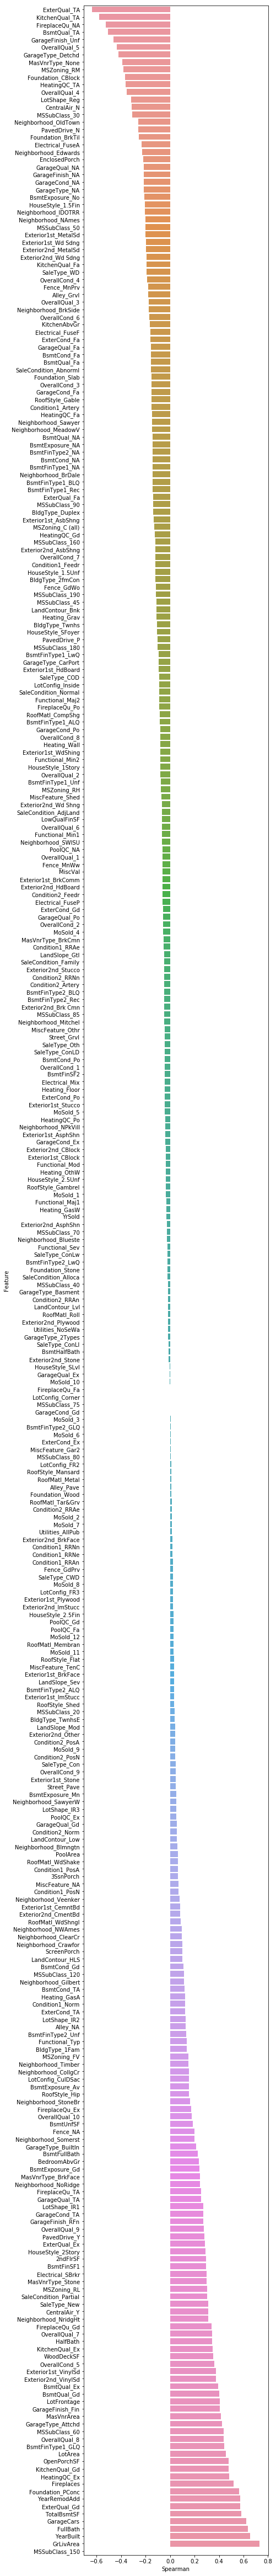

In [36]:
# use spearman coorlation to find features most coorelated with saleprice
spearman = pd.DataFrame()
features = num_features + cat_data.columns.tolist()
new_df = all_data[0:df_target.shape[0]]
spearman['Feature'] = features
spearman['Spearman'] = [new_df[f].corr(df_train['SalePrice'], 'spearman') for f in features]
spearman = spearman.sort_values('Spearman')
plt.figure(figsize=(6, 0.25*len(features)))
sns.barplot(data=spearman, y='Feature', x='Spearman', orient='h')

In [37]:
# refine features to those most coorelated to sale price
# cutoff value chosen by comparing model error (below) for different values
spearman_cutoff = 0.1
refined_features = spearman[np.abs(spearman['Spearman'])>spearman_cutoff].Feature.tolist()
ref_df = all_data[refined_features]

In [38]:
# Final dataframes
train = ref_df[0:ntrain]
test = ref_df[ntrain:]
target = df_target

# Print sizes of dataframes for modeling
print('Data Frame Sizes:')
print('Training: ', train.shape)
print('Target: ' , target.shape)
print('Testing: ' , test.shape)

Data Frame Sizes:
Training:  (1458, 166)
Target:  (1458,)
Testing:  (1459, 166)


# Modeling
linear regression

In [39]:
# Divide training data for cross validation
test_size = 0.3
X_train, X_val, y_train, y_val = train_test_split(train, target,test_size = test_size, random_state=0)
print('Data divided for cross validation')
print('X_train: ', X_train.shape[0])
print('X_val: ', X_val.shape[0])
print('y_train: ', y_train.shape[0])
print('y_val: ', y_val.shape[0])

Data divided for cross validation
X_train:  1020
X_val:  438
y_train:  1020
y_val:  438


In [40]:
# Define scoring with cross validation
n_folds = 5
def rmse_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = n_folds))
    return(rmse)
def rmse_val(model):
    rmse= np.sqrt(-cross_val_score(model, X_val, y_val, scoring="neg_mean_squared_error", cv = n_folds))
    return(rmse)

In [41]:
#  Keep track of model validation errors
models = {}

In [42]:
# Linear Regression without Regularization
lr = LinearRegression()
lr.fit(X_train, y_train)
print ('Linear Regression')
print('Training Error: ', rmse_train(lr).mean())
print('Validation Error: ', rmse_val(lr).mean())
models['LinearRegression'] = rmse_val(lr).mean()

Linear Regression
Training Error:  840828061.6882743
Validation Error:  2466861615.8631525


In [43]:
# Ridge Regression
print('Ridge CV')

# Find alpha
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

# Eliminated features
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")

# Get model error
print('Training Error: ', rmse_train(ridge).mean())
print('Validation Error: ', rmse_val(ridge).mean())
models['RidgeCV'] = rmse_val(ridge).mean()

Ridge CV
Best alpha : 3.0
Try again for more precision with alphas centered around 3.0
Best alpha : 4.199999999999999
Ridge picked 166 features and eliminated the other 0 features
Training Error:  0.12129607971053709
Validation Error:  0.13347362306298052


In [44]:
# Lasso Regression
print('Lasso CV')

# Find alpha
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

# Eliminated features
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")

# Get model error
print('Training Error: ', rmse_train(lasso).mean())
print('Validation Error: ', rmse_val(lasso).mean())
models['LassoCV'] = rmse_val(lasso).mean()

Lasso CV
Best alpha : 0.0003
Try again for more precision with alphas centered around 0.0003
Best alpha : 0.00025499999999999996
Lasso picked 125 features and eliminated the other 41 features
Training Error:  0.1228236878867495
Validation Error:  0.1279853971828359


In [45]:
models

{'LinearRegression': 2466861615.8631525,
 'RidgeCV': 0.13347362306298052,
 'LassoCV': 0.1279853971828359}

# Run Model on Test Data

In [46]:
test['SalePrice'] = np.expm1(lasso.predict(test))
test['Id'] = test_IDs

In [47]:
# Final submission file
df_submit = test[['Id', 'SalePrice']]
df_submit.to_csv("../working/ridgeCV.csv", index=False)

In [48]:
df_submit.head()

,Id,SalePrice
0,1461,117825.466
1,1462,158164.342
2,1463,189544.768
3,1464,198357.768
4,1465,199085.355
